# **Training Menggunakan ResNet50 (Transfer Learning imageNet) Training asli + Training Augmentasi**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import multiprocessing

In [ ]:
path_original = "/content/drive/MyDrive/Skripsi_Dataset/Dataset/Gabungan Train+Val"
path_augmented = "/content/drive/MyDrive/Skripsi_Dataset/Dataset_Augmented/Data Train Gabungan"

In [ ]:
# ====== LOAD DATA TRAINING ======
key_value = dict()
for i in os.listdir(path_original):
    key_value[i] = os.listdir(os.path.join(path_original, i))

df_orig = []
for key in key_value.keys():
    for j in key_value[key]:
        df_orig.append([key, os.path.join(path_original, key, j)])
df_orig = pd.DataFrame(df_orig, columns=('label', 'path'))
print("Total gambar training asli:", len(df_orig))

Total gambar training asli: 1649


In [ ]:
key_value_aug = dict()
for i in os.listdir(path_augmented):
    key_value_aug[i] = os.listdir(os.path.join(path_augmented, i))

df_aug = []
for key in key_value_aug.keys():
    for j in key_value_aug[key]:
        df_aug.append([key, os.path.join(path_augmented, key, j)])
df_aug = pd.DataFrame(df_aug, columns=('label', 'path'))
print("Total gambar training augmentasi:", len(df_aug))

Total gambar training augmentasi: 1649


In [ ]:
df = pd.concat([df_orig, df_aug], ignore_index=True)
print("Total gambar setelah digabung:", len(df))

Total gambar setelah digabung: 3298


In [ ]:
# # ====== LOAD GAMBAR TRAINING ======
# def readimg(path):
#     img = cv.imread(path)
#     img = cv.resize(img, (224, 224))
#     return img

# with multiprocessing.Pool(2) as p:
#     images = p.map(readimg, df['path'])

# images = np.array(images, dtype='float')

In [ ]:
# ====== LOAD GAMBAR TRAINING ======
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    img = img.astype(np.float32)
    return img

images = []
for path in df['path']:
    images.append(readimg(path))

images = np.array(images, dtype=np.float32)

In [ ]:
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(df['label'])

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(
    images, y_labels, test_size=0.2, random_state=1
)

In [ ]:
print(f"Jumlah data train : {len(train_images)}")
print(f"Jumlah data val   : {len(val_images)}")

Jumlah data train : 2638
Jumlah data val   : 660


In [ ]:
# ===================== LOAD MODEL 1 ============================
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOri.keras"
model = keras.models.load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,912,992 (114.11 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,216,854 (16.09 MB)

In [ ]:
# ================= Freeze Base Model ==========================
for layer in model.layers[0].layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
# ## implementing trensfer learning
# base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # freezing the base model so we donot have to train it again
# base_model.trainable = False

# model = keras.Sequential([
#   base_model,
#   keras.layers.GlobalAveragePooling2D(),
#   keras.layers.Dense(1024, activation='relu'),
#   keras.layers.Dense(10, activation='softmax')
# ])
# model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(val_images, val_labels),
    shuffle=True
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.9040 - loss: 0.4234 - val_accuracy: 0.9318 - val_loss: 0.2917
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9221 - loss: 0.2697 - val_accuracy: 0.9470 - val_loss: 0.2411
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9418 - loss: 0.2067 - val_accuracy: 0.9561 - val_loss: 0.1905
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.9561 - loss: 0.1394 - val_accuracy: 0.9606 - val_loss: 0.1764
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9633 - loss: 0.1108 - val_accuracy: 0.9424 - val_loss: 0.1990
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9752 - loss: 0.0913 - val_accuracy: 0.9606 - val_loss: 0.1718
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9809 - loss: 0.0717 - val_accuracy: 0.9606 - val_loss: 0.1522
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9794 - loss: 0.0626 - val_accuracy: 0

In [ ]:
# ===================== SIMPAN HISTORY KE CSV ============================
# Mengubah history ke DataFrame
hist_df = pd.DataFrame(history.history)

# Menentukan path penyimpanan di Google Drive
csv_path = "/content/drive/MyDrive/Skripsi_Dataset/Csv Training/ResNet50_TL_TrainOriAug_Model1.csv"

# Simpan ke CSV
hist_df.to_csv(csv_path, index=False)

print(f"Hasil training telah disimpan ke: {csv_path}")

Hasil training telah disimpan ke: /content/drive/MyDrive/Skripsi_Dataset/Csv Training/ResNet50_TL_TrainOriAug_Model1.csv


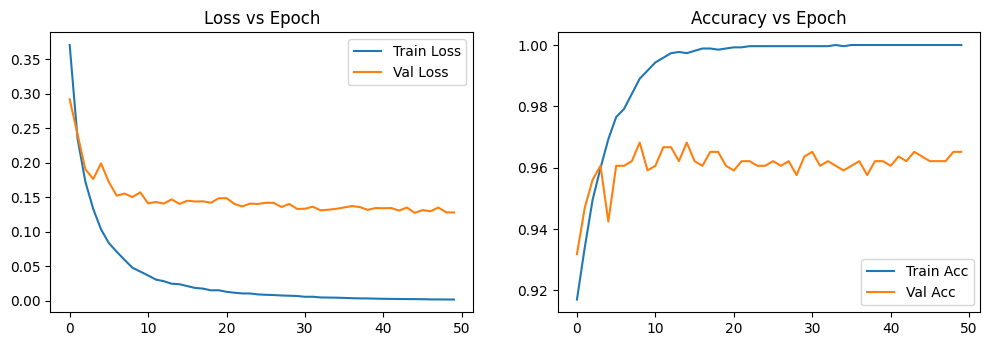

In [ ]:
# Grafik Loss dan Akurasi
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy vs Epoch')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        63
           1     0.9730    1.0000    0.9863        72
           2     0.9697    0.9412    0.9552        68
           3     0.9600    0.9730    0.9664        74
           4     0.9855    0.9577    0.9714        71
           5     1.0000    1.0000    1.0000        66
           6     0.9206    0.9667    0.9431        60
           7     0.9167    0.9322    0.9244        59
           8     0.9429    0.9429    0.9429        70
           9     0.9815    0.9298    0.9550        57

    accuracy                         0.9652       660
   macro avg     0.9650    0.9643    0.9645       660
weighted avg     0.9656    0.9652    0.9652       660



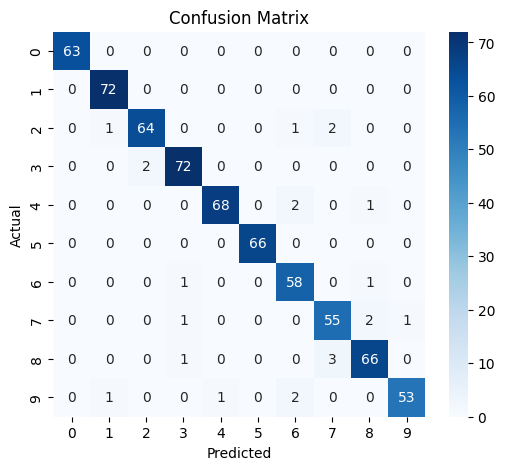

In [ ]:
pred = model.predict(val_images)
pred_labels = np.argmax(pred, axis=1)

print("\nClassification Report:")
print(classification_report(val_labels, pred_labels, target_names=le.classes_, digits=4))

cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru"
os.makedirs(save_path, exist_ok=True)

model_name_keras = "ResNet50_TL_TrainOriAug_Model1.keras"
model_name_h5 = "ResNet50_TL_TrainOriAug_Model1.h5"

full_path_keras = os.path.join(save_path, model_name_keras)
full_path_h5 = os.path.join(save_path, model_name_h5)

model.save(full_path_keras)
model.save(full_path_h5)

print("\n Model berhasil disimpan dalam format .keras dan .h5")
print(f"Lokasi Keras: {full_path_keras}")
print(f"Lokasi H5: {full_path_h5}")



 Model berhasil disimpan dalam format .keras dan .h5
Lokasi Keras: /content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOriAug_Model1.keras
Lokasi H5: /content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOriAug_Model1.h5


# **DATA TEST ASLI**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOriAug_Model1.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Dataset/Test_Images"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test baru:", len(df_test_new))

Total gambar test baru: 413


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test baru...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test baru...
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST ASLI TANPA AUGMENTASI ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST ASLI TANPA AUGMENTASI ===
Accuracy : 0.9419
Precision: 0.9439
Recall   : 0.9431
F1-Score : 0.9431


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        47
           1     1.0000    0.9714    0.9855        35
           2     0.9750    0.9070    0.9398        43
           3     0.9762    1.0000    0.9880        41
           4     0.9302    0.9524    0.9412        42
           5     1.0000    1.0000    1.0000        40
           6     0.9211    0.9459    0.9333        37
           7     0.8537    0.7955    0.8235        44
           8     0.8333    0.9091    0.8696        44
           9     0.9500    0.9500    0.9500        40

    accuracy                         0.9419       413
   macro avg     0.9439    0.9431    0.9431       413
weighted avg     0.9427    0.9419    0.9418       413



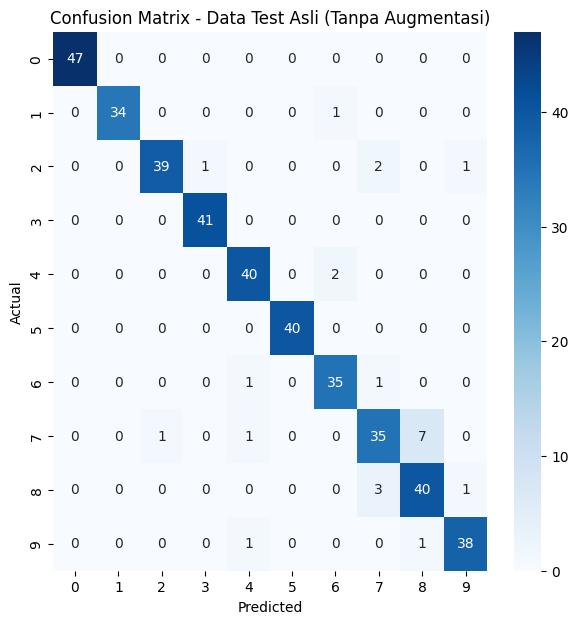

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Asli (Tanpa Augmentasi)")
plt.show()

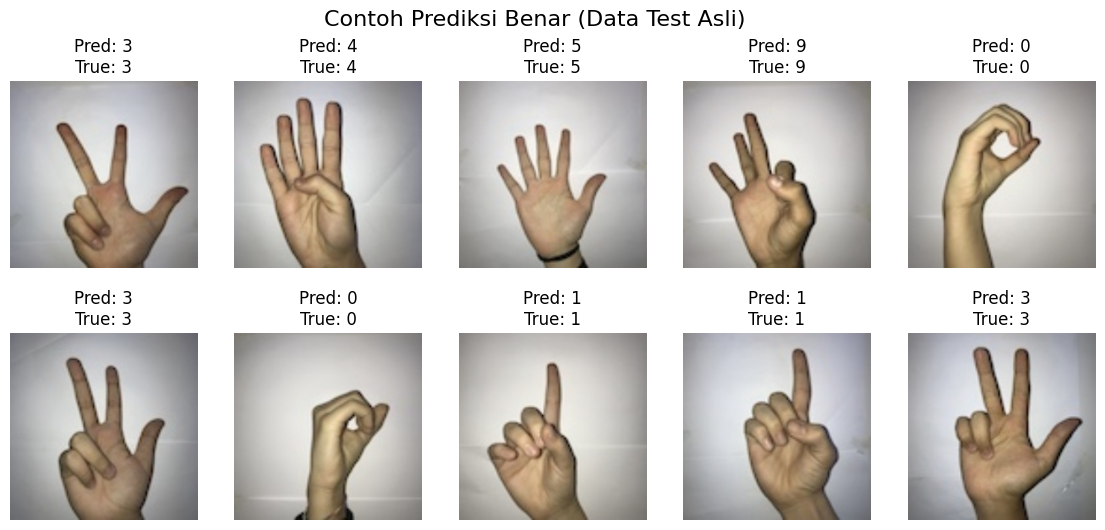

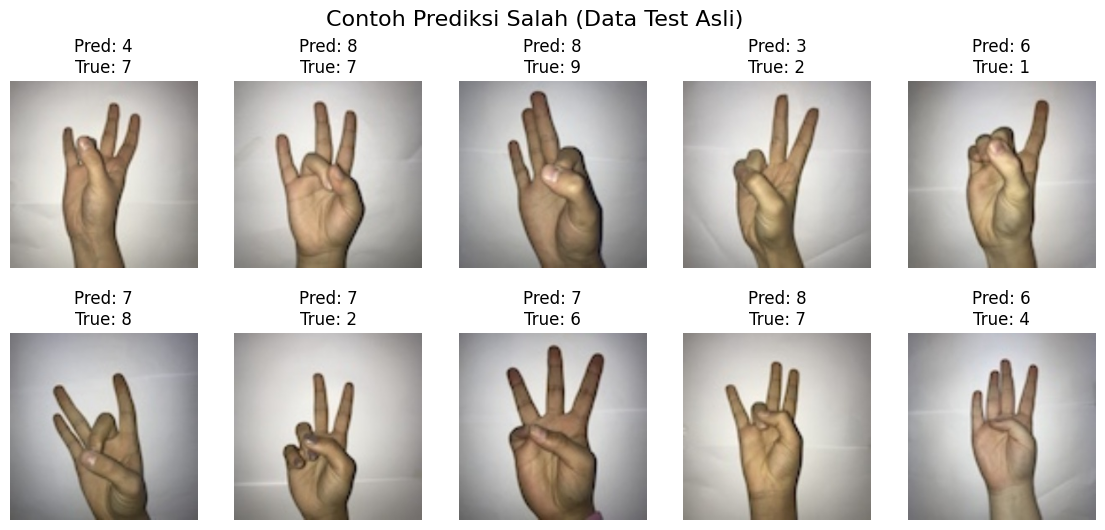

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Asli)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Asli)")

# **DATA TEST AUGMENTASI**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOriAug_Model1.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Dataset_Augmented/Data_Test"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test baru:", len(df_test_new))

Total gambar test baru: 413


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test augmentasi...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test augmentasi...
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST AUGMENTASI ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST AUGMENTASI ===
Accuracy : 0.9225
Precision: 0.9259
Recall   : 0.9241
F1-Score : 0.9240


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9400    1.0000    0.9691        47
           1     0.9714    0.9714    0.9714        35
           2     0.9091    0.9302    0.9195        43
           3     0.9070    0.9512    0.9286        41
           4     0.9512    0.9286    0.9398        42
           5     1.0000    0.9750    0.9873        40
           6     1.0000    0.9189    0.9577        37
           7     0.7907    0.7727    0.7816        44
           8     0.9231    0.8182    0.8675        44
           9     0.8667    0.9750    0.9176        40

    accuracy                         0.9225       413
   macro avg     0.9259    0.9241    0.9240       413
weighted avg     0.9237    0.9225    0.9221       413



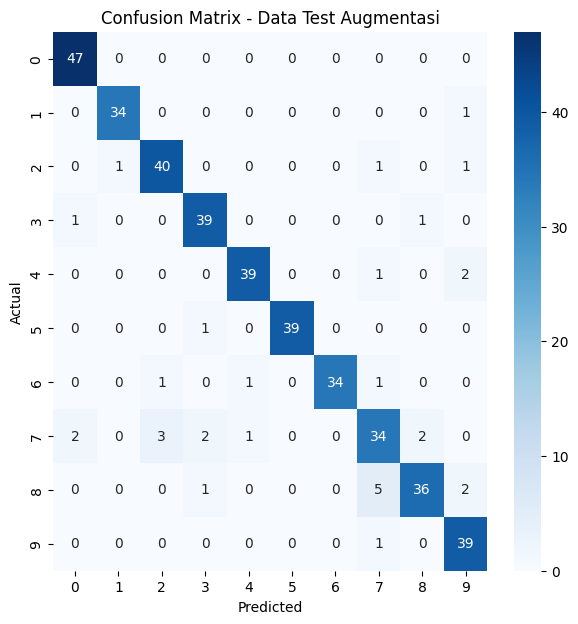

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Augmentasi")
plt.show()

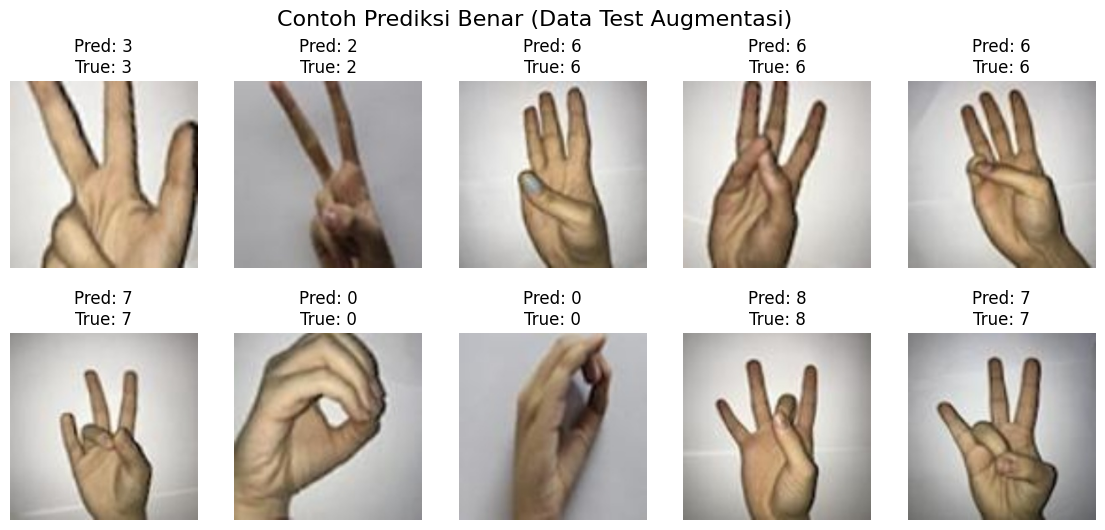

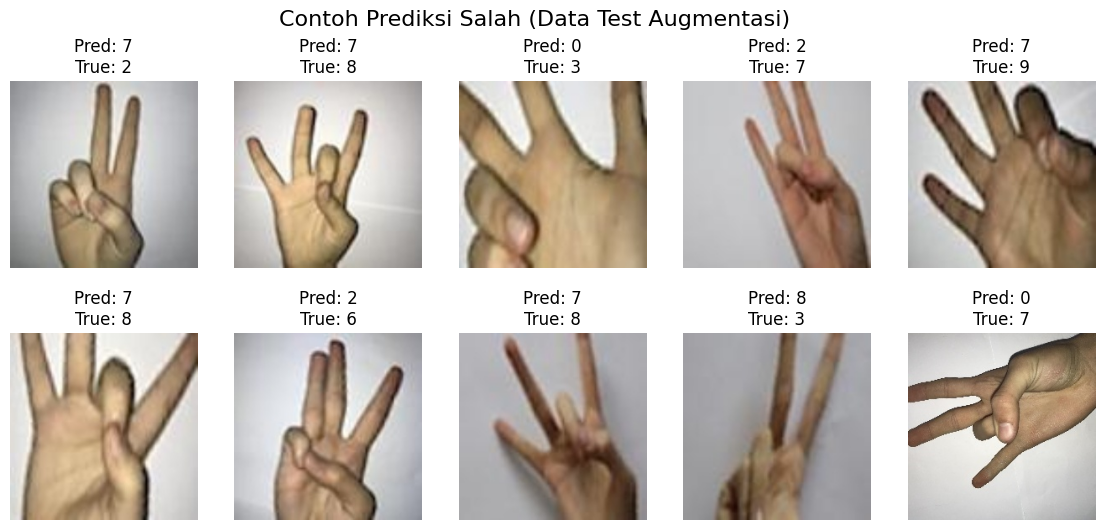

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Augmentasi)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Augmentasi)")

# **DATA TEST GABUNGAN**

In [ ]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_path = "/content/drive/MyDrive/Skripsi_Dataset/Model Baru/ResNet50_TL_TrainOriAug_Model1.keras"
test_new_dir = "/content/drive/MyDrive/Skripsi_Dataset/Data Test Gabungan"

In [ ]:
print("Memuat model yang sudah dilatih...")
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat!")

Memuat model yang sudah dilatih...
Model berhasil dimuat!


In [ ]:
key_value_test_new = dict()
for i in os.listdir(test_new_dir):
    key_value_test_new[i] = os.listdir(os.path.join(test_new_dir, i))

In [ ]:
df_test_new = []
for key in key_value_test_new.keys():
    for j in key_value_test_new[key]:
        df_test_new.append([key, os.path.join(test_new_dir, key, j)])
df_test_new = pd.DataFrame(df_test_new, columns=('label', 'path'))
print("Total gambar test gabungan:", len(df_test_new))

Total gambar test gabungan: 826


In [ ]:
def readimg(path):
    img = cv.imread(path)
    img = cv.resize(img, (224, 224))
    return img

In [ ]:
import multiprocessing
with multiprocessing.Pool(4) as p:
    test_images_new = p.map(readimg, df_test_new['path'])

test_images_new = np.array(test_images_new, dtype='float')

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_test_new['label'])
test_labels_new = le.transform(df_test_new['label'])

In [ ]:
print("\n Melakukan prediksi pada data test gabungan...")
predictions_new = model.predict(test_images_new)
predicted_labels_new = np.argmax(predictions_new, axis=1)


 Melakukan prediksi pada data test gabungan...
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step


In [ ]:
accuracy = accuracy_score(test_labels_new, predicted_labels_new)
precision = precision_score(test_labels_new, predicted_labels_new, average='macro')
recall = recall_score(test_labels_new, predicted_labels_new, average='macro')
f1 = f1_score(test_labels_new, predicted_labels_new, average='macro')

In [ ]:
print("\n=== HASIL EVALUASI DATA TEST GABUNGAN ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


=== HASIL EVALUASI DATA TEST GABUNGAN ===
Accuracy : 0.9322
Precision: 0.9336
Recall   : 0.9336
F1-Score : 0.9334


In [ ]:
target_class_names = le.classes_
print("\nClassification Report:")
print(classification_report(test_labels_new, predicted_labels_new, target_names=target_class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9691    1.0000    0.9843        94
           1     0.9855    0.9714    0.9784        70
           2     0.9405    0.9186    0.9294        86
           3     0.9412    0.9756    0.9581        82
           4     0.9405    0.9405    0.9405        84
           5     1.0000    0.9875    0.9937        80
           6     0.9583    0.9324    0.9452        74
           7     0.8214    0.7841    0.8023        88
           8     0.8736    0.8636    0.8686        88
           9     0.9059    0.9625    0.9333        80

    accuracy                         0.9322       826
   macro avg     0.9336    0.9336    0.9334       826
weighted avg     0.9318    0.9322    0.9318       826



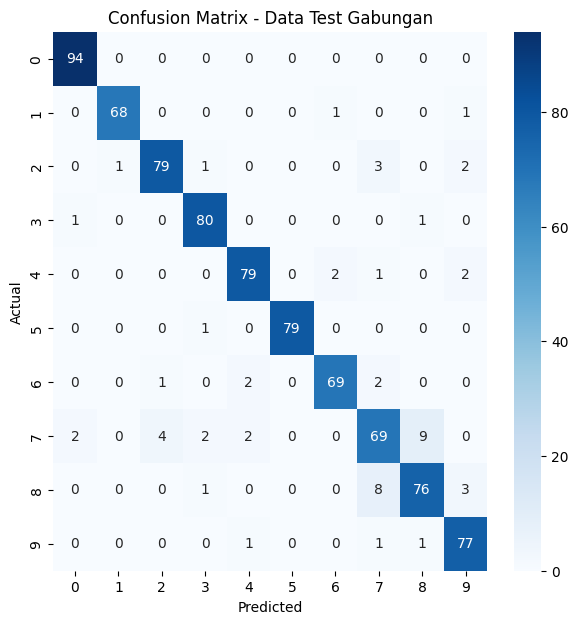

In [ ]:
plt.figure(figsize=(7,7))
cm = confusion_matrix(test_labels_new, predicted_labels_new)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=target_class_names,
            yticklabels=target_class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Data Test Gabungan")
plt.show()

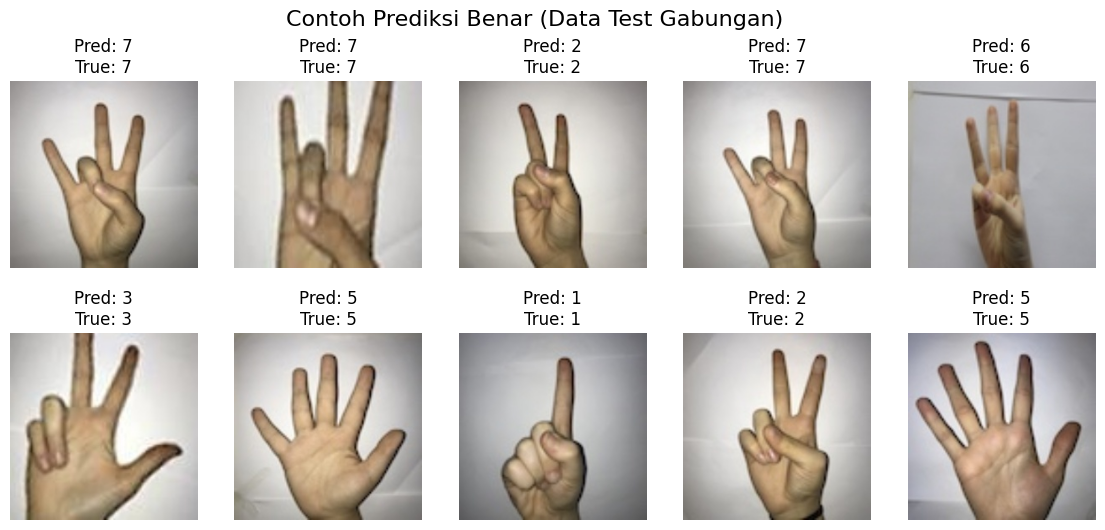

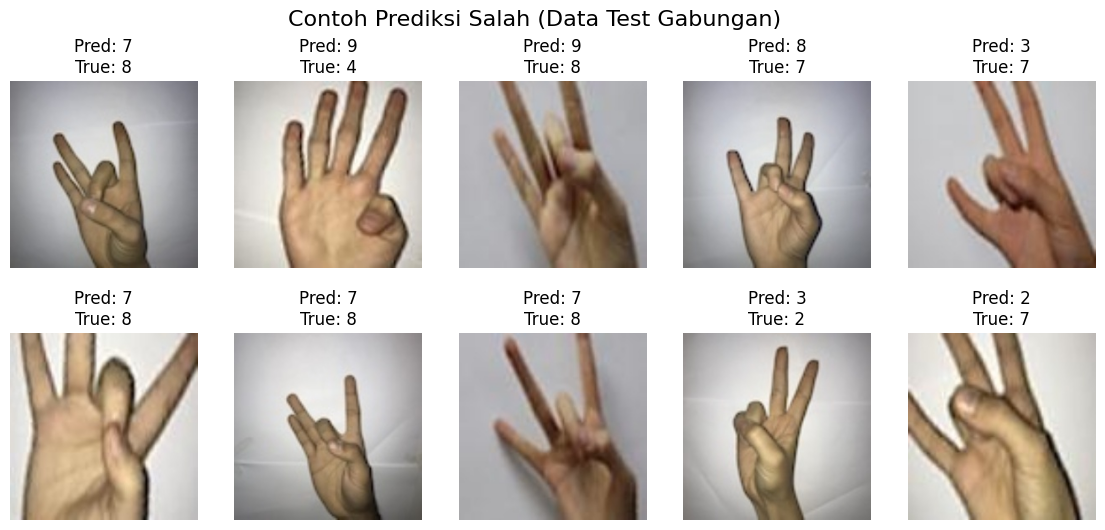

In [ ]:
import random

correct_idx = np.where(predicted_labels_new == test_labels_new)[0]
incorrect_idx = np.where(predicted_labels_new != test_labels_new)[0]

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(random.sample(list(indices), min(10, len(indices)))):
        plt.subplot(2, 5, i + 1)
        img = cv.cvtColor(test_images_new[idx].astype('uint8'), cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Pred: {target_class_names[predicted_labels_new[idx]]}\nTrue: {target_class_names[test_labels_new[idx]]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(correct_idx, "Contoh Prediksi Benar (Data Test Gabungan)")
show_images(incorrect_idx, "Contoh Prediksi Salah (Data Test Gabungan)")